In [1]:
import numpy as np
import torch 
import torch.nn as nn
import os 
from collections import OrderedDict

from utils.sample_parameters import ParamSamples
from utils.custom_loss import profit_loss
from utils.train_n_test import TrainTest
from models.LSTM_CNN_concat import LSTM_CNN_concat

In [2]:
params_dict = {
    # HYPERMARAMETER RANGES
    'BATCH_SIZE': ([48, 64, 128, 256, 512], None), 
    'EPOCHS': ([20, 40, 50], None),
    'OPTIMIZER': ([torch.optim.RMSprop], None),
    'LEARNING_RATE': ([1e-5, 5e-5, 1e-4, 5e-4, 1e-3], None),
    'LOSS': ([torch.nn.MSELoss()], None),
    'EARLY_STOPPING': ([True], None),
    'PATIENCE': (list(range(0,3)), None),
    'MIN_DELTA': ([1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4], None),

    # NETWORK PARAMETER RANGES
    'DROPOUT': (np.arange(8)/10, None),
    ## CNN 
    'CNN_HIDDEN_DEPTH': (np.arange(2, 5), None),
    'CNN_HIDDEN_SIZES': ([64, 128, 256, 512], 
                       {'max_depth': 'CNN_HIDDEN_DEPTH', # sample a list of maximum HIDDEN_DEPTH length 
                        'consecutive': 1}), # list must be increasing 
    'KERNEL_SIZES': ([3,5,7,9], 
                        {'max_depth': 'CNN_HIDDEN_DEPTH', 
                        'monotonic': -1}),  
    'MAXPOOL': ([2], None),
    
    ## LSTM
    'LSTM_HIDDEN_DIM': ([64, 128, 256], None),
    'NUM_LAYERS':([1],None),
    'BIDIRECTIONAL': ([True, False], None),
    
    ## FC
    'FC_DEPTH':  (np.arange(1,3), None),
    'FC_SIZES': ([256, 512], 
                    {'max_depth': 'FC_DEPTH',
                    'consecutive': -1}),
}

In [3]:
fixed_params =[{'BATCH_SIZE': 256,
  'EPOCHS': 20,
  'OPTIMIZER': torch.optim.RMSprop,
  'LEARNING_RATE': 0.001,
  'LOSS': torch.nn.MSELoss(),
  'EARLY_STOPPING': True,
  'PATIENCE': 0,
  'MIN_DELTA': 5e-06,
  'DROPOUT': 0.1,
  'CNN_HIDDEN_DEPTH': 4,
  'CNN_HIDDEN_SIZES': np.array([ 64, 128, 256, 512]),
  'KERNEL_SIZES': np.array([9,7, 5, 3]),
  'MAXPOOL': 2,
  'LSTM_HIDDEN_DIM': 128,
  'NUM_LAYERS': 1,
  'BIDIRECTIONAL': True,
  'FC_DEPTH': 1,
  'FC_SIZES': np.array([512])}]

In [4]:
N = 1
PKL_NAMES = [i for i in os.listdir('data/tensors') if 'expt0' in i ]
PKL_NAMES = [i for i in PKL_NAMES if 'persistence' not in i ]

In [5]:
PKL_NAMES = [PKL_NAMES[-1]]

In [6]:
for pkl in PKL_NAMES: 
    PKL_NAME = pkl[:-4] 
    print(PKL_NAME)
    train, val, test = torch.load('data/tensors/'+ PKL_NAME + '.pkl')
    persistence = torch.load('data/tensors/'+ PKL_NAME + '_persistence.pkl')
    
    torch.nn.MSELoss()(persistence, test[1])
    
    params = ParamSamples(OrderedDict(params_dict))
    param_samples = params.SampleAll(N)
    
    stats = []
    predictions = []
    for i in np.arange(N): 
        print(param_samples[i])
        run = TrainTest(LSTM_CNN_concat, (train, val, test), param_samples[i], class_size=1)
        run.train()
        stats.append(run.test())
        predictions.append(run.predictions)

    for i in np.arange(N):
        for key,val in stats[i].items():
            param_samples[i][key] = val

    torch.save(param_samples, 'results/LSTM-CNN_concat_experiment_N'+str(N)+'_'+PKL_NAME+'.pkl')

expt0_mean_speeds_mean_dirs_1dtime_original_interpolation


/home/kristoforus/miniconda3/envs/deeplearning/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/514 [00:00<?, ?it/s]

{'BATCH_SIZE': 48, 'EPOCHS': 50, 'OPTIMIZER': <class 'torch.optim.rmsprop.RMSprop'>, 'LEARNING_RATE': 0.0005, 'LOSS': MSELoss(), 'EARLY_STOPPING': True, 'PATIENCE': 1, 'MIN_DELTA': 1e-06, 'DROPOUT': 0.2, 'CNN_HIDDEN_DEPTH': 3, 'CNN_HIDDEN_SIZES': array([128, 256, 512]), 'KERNEL_SIZES': array([7, 5, 5]), 'MAXPOOL': 2, 'LSTM_HIDDEN_DIM': 256, 'NUM_LAYERS': 1, 'BIDIRECTIONAL': False, 'FC_DEPTH': 1, 'FC_SIZES': array([256])}


  0%|          | 0/514 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.5362308621406555, valid_loss: 0.026442550122737885


  0%|          | 0/514 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.007217629812657833, valid_loss: 0.025407610461115837


  0%|          | 0/514 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.005890069995075464, valid_loss: 0.02134351059794426


  0%|          | 0/514 [00:00<?, ?it/s]

decrease in val loss < min_delta, patience count:  1
Epoch: 3, train_loss: 0.00529502984136343, valid_loss: 0.024459179490804672


100%|██████████| 64/64 [00:05<00:00, 12.45it/s]


Early stopped at Epoch:  4


In [7]:
run.stats

{'epoch_stopped': 4,
 'train_time': 759.3124034404755,
 'test_loss': tensor(0.0183),
 'mean_train_loss': [0.53623086,
  0.0072176317,
  0.005890067,
  0.005295027,
  0.0046252566],
 'mean_val_loss': [0.026442546, 0.02540761, 0.021343509, 0.024459181],
 'min_val_loss': 0.021343509,
 'predictions': tensor([-0.1788, -0.1783, -0.0866,  ..., -0.0683, -0.0048,  0.1066]),
 'bal_list': array([1.00000000e+07, 9.91556143e+06, 9.86063918e+06, ...,
        5.08899160e+08, 5.09104754e+08, 5.09305579e+08])}

tensor(0.0197), 1.66497559e+09

<IPython.core.display.Javascript object>


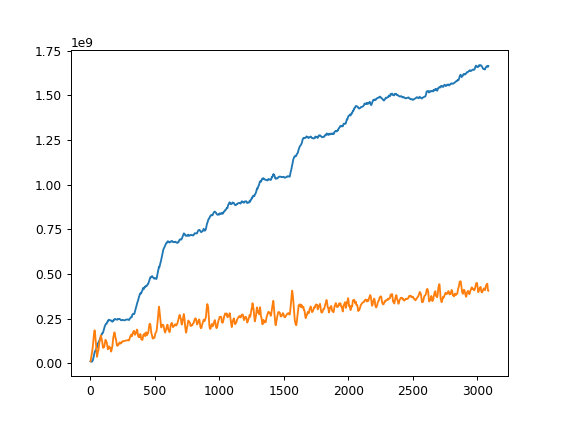

In [86]:
import matplotlib.pyplot as plt

from utils.custom_loss import Balance
pers_balance = Balance(1e7, 10, 100, (0,87000), 'minmax')
pers_balance.update(persistence, test[1], test[0][:,-1,1])

plt.plot(run.bal.balance_list)
plt.plot(pers_balance.balance_list)

In [83]:
dif = stats[0]['bal_list'][1:] - stats[0]['bal_list'][:-1]

<IPython.core.display.Javascript object>


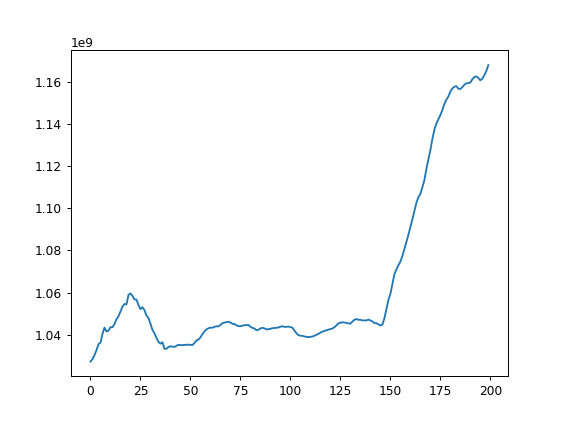

In [96]:
plt.plot(stats[0]['bal_list'][1400:1600])

<IPython.core.display.Javascript object>


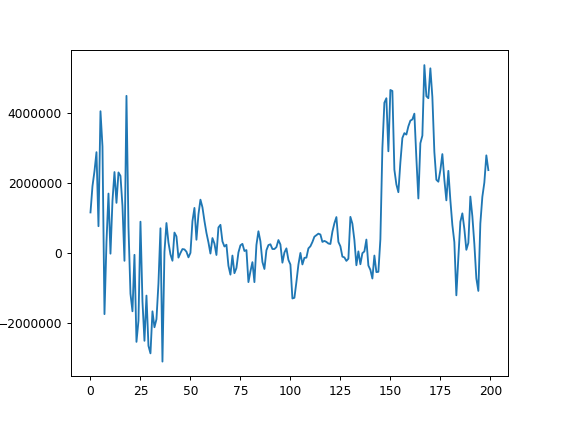

In [93]:
plt.plot(dif[1400:1600])

<IPython.core.display.Javascript object>


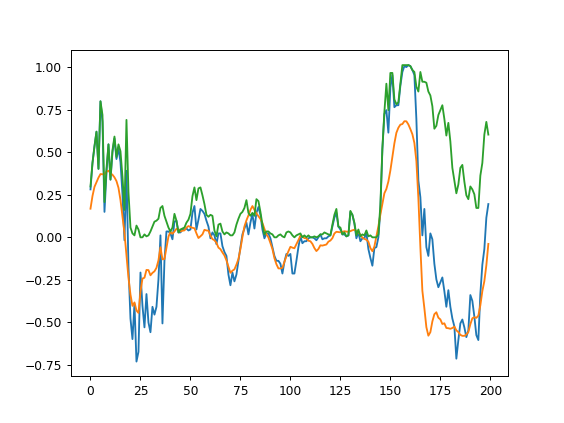

In [99]:
plt.plot(test[1][1400:1600])
plt.plot(run.predictions[1400:1600])
plt.plot((test[0][:,-1,1] + test[1])[1400:1600])

<IPython.core.display.Javascript object>


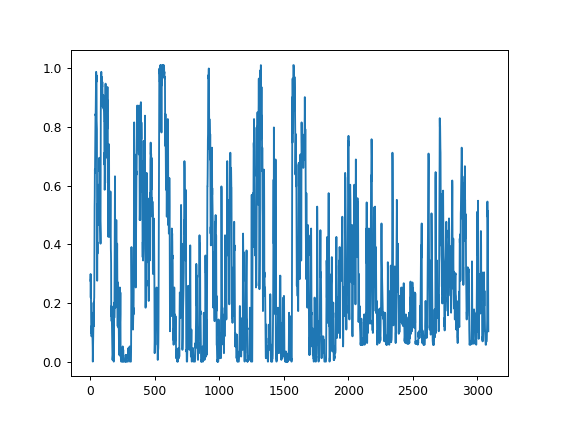

In [100]:
plt.plot(test[0][:, -1,1][1400:1600])

0

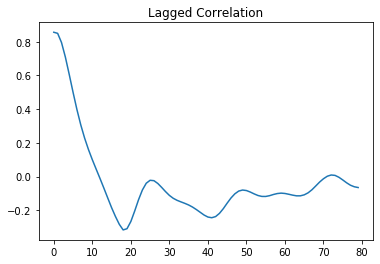

In [23]:
# Visualise Lagged Correlation
from utils.visuals import lagged_correlation
corr = lagged_correlation(run.predictions, test[1], plot=True)
np.amax(corr) 
np.argmax(corr)   

In [51]:
from utils.visuals import SliceGenerator
sg = SliceGenerator(run.model, test[0], test[1])

In [81]:
sg.right()

IndexError: index 3088 is out of bounds for dimension 0 with size 3088

<IPython.core.display.Javascript object>


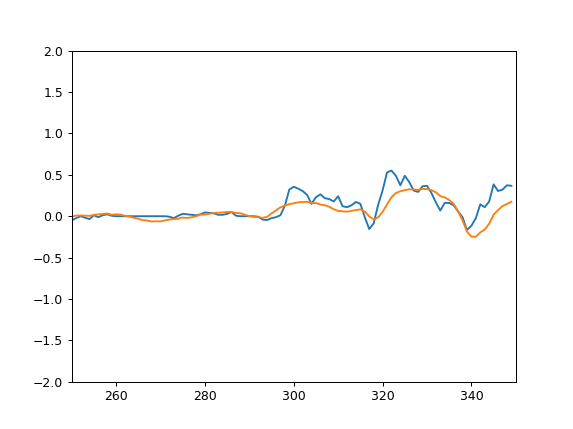

In [25]:
# Can't find a way to make this a function (plot not showing), so putting this in every notebook 
from matplotlib.animation import FuncAnimation
%matplotlib notebook

interval = 50
windowsize = 100
test_ = test[1]
pred = run.predictions

fig  = plt.figure()
ax   = plt.axes(xlim=(0, windowsize), ylim=(-2, 2))
ln1, = plt.plot([],[])
ln2, = plt.plot([],[])

def update_animation(f):
    r = np.arange(f, f + windowsize)
    lim = ax.set_xlim(f, f+ windowsize)
    ln1.set_data(r, test_[r])
    ln2.set_data(r, pred[r])

frames = np.arange(0, len(pred), interval)
ani = FuncAnimation(fig, update_animation, frames=frames) 
plt.show()